In [1]:
#Import necessary libraries - should work mostly from BCI_analysis + matplotlib + numpy
import BCI_analysis
from BCI_analysis.pipeline import pipeline_regression
import importlib
importlib.reload(pipeline_regression)
importlib.reload(BCI_analysis)
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

No module named 'cellpose'
cannot use anatomical mode, but otherwise suite2p will run normally


In [2]:
# load from python raw data

# define base directories, if necessary
# define subject/FOV/session/
importlib.reload(BCI_analysis.pipeline_align)
multisession_mat_file = os.path.abspath("/home/jupyter/bucket/Data/Calcium_imaging/multi_session_mat/combined_new_old2.mat")
dlc_base_dir = os.path.abspath("/home/jupyter/bucket/Data/Behavior_videos/DLC_output/Bergamo-2P-Photostim/")
bpod_path = os.path.abspath("/home/jupyter/bucket/Data/Behavior/BCI_exported/Bergamo-2P-Photostim/")
suite2p_path = os.path.abspath("/home/jupyter/bucket/Data/Calcium_imaging/suite2p/Bergamo-2P-Photostim/")
sessionwise_data_path = os.path.abspath("/home/jupyter/bucket/Data/Calcium_imaging/sessionwise_tba/")
aligned_data_path = os.path.abspath("/home/jupyter/bucket/Data/Calcium_imaging/data_aligned/")
plt_save_path = os.path.abspath("/home/jupyter/Plots/")
face_rhythm_base_dir = '/home/jupyter/bucket/Data/Behavior_videos/FaceRhythm/'
motion_energy_base_dir = os.path.abspath("/home/jupyter/bucket/Data/Behavior_videos/MotionEnergy/Bergamo-2P-Photostim/")
raw_video_path = os.path.abspath("/home/jupyter/bucket/Data/Behavior_videos/raw/Bergamo-2P-Photostim/")

mouse = "BCI_34"
FOV = "FOV_04"
camera = "side"
session = "071922"

# match calcium imaging frames with DLC frames, extract all data in a nice structure
# it doesn't have to have the actual calcium traces, the frame indices are enough, since we'll select the calcium traces in a next step, since probably this cell will be the slowest
# should have the option for averaging/std calculation on variable windows, then downsampling
# should have the option for excluding post-reward activity
multi_session_dict = {'mouse':[],
                     'session':[],
                      'mat_idx':[],
                     'cn':[],
                     'DLC_aligned':[],
                     'F':[],
                     'trial_end_frames':[]}
dict_aligned = BCI_analysis.pipeline_align.get_aligned_data(suite2p_path, 
                                                            dlc_base_dir, 
                                                            bpod_path, 
                                                            sessionwise_data_path, 
                                                            aligned_data_path, 
                                                            motion_energy_base_dir,
                                                            raw_video_path,
                                                            mouse=mouse, 
                                                            FOV=FOV, 
                                                            camera=camera, 
                                                            session=session, 
                                                            sampling='down', 
                                                            functions = ['diff','diff_signed','mean'],
                                                            function_window = 20,  ### important variable for downsampling 1 for facerhythm - 20/200 for 
                                                            convolve_tau = 0.7, #.7
                                                            plot = False,
                                                            overwrite=False,
                                                            use_provided_data=False,
                                                            add_motion_energy = True,
                                                            source_data = None,
                                                            face_rhythm_base_dir = face_rhythm_base_dir,
                                                            use_face_rhythm = False,
                                                            match_with_face_rhythm = False)
DLC_aligned = pd.DataFrame.from_dict(dict_aligned['DLC_aligned'])
F = np.concatenate(dict_aligned['F_aligned'], axis=1)
multi_session_dict['mouse'].append(mouse)
multi_session_dict['session'].append(session)
multi_session_dict['cn'].append(dict_aligned['cn'])
multi_session_dict['mat_idx'].append(None)
multi_session_dict['DLC_aligned'].append(DLC_aligned)
multi_session_dict['F'].append(F)
multi_session_dict['trial_end_frames'].append(dict_aligned['trial_start_indices'])
#break
print(dict_aligned.keys())


File found at /home/jupyter/bucket/Data/Calcium_imaging/data_aligned/BCI_34/071922-dict_aligned-downsampled.npy
dict_keys(['F_aligned', 'DLC_aligned', 'dff_aligned', 'lick_times_aligned', 'reward_times_aligned', 'trial_times_aligned', 'cn', 'trials_taken', 'trial_start_indices'])


In [2]:
# explain fecerhythm with DLC and vice versa
import json,hdfdict,tqdm
add_motion_energy = True
multisession_mat_file = os.path.abspath("/home/jupyter/bucket/Data/Calcium_imaging/multi_session_mat/combined_new_old2.mat")
dlc_base_dir = os.path.abspath("/home/jupyter/bucket/Data/Behavior_videos/DLC_output/Bergamo-2P-Photostim/")
bpod_path = os.path.abspath("/home/jupyter/bucket/Data/Behavior/BCI_exported/Bergamo-2P-Photostim/")
suite2p_path = os.path.abspath("/home/jupyter/bucket/Data/Calcium_imaging/suite2p/Bergamo-2P-Photostim/")
sessionwise_data_path = os.path.abspath("/home/jupyter/bucket/Data/Calcium_imaging/sessionwise_tba/")
aligned_data_path = os.path.abspath("/home/jupyter/bucket/Data/Calcium_imaging/data_aligned/")
plt_save_path = os.path.abspath("/home/jupyter/Plots/")
face_rhythm_base_dir = '/home/jupyter/bucket/Data/Behavior_videos/FaceRhythm/'
motion_energy_base_dir = os.path.abspath("/home/jupyter/bucket/Data/Behavior_videos/MotionEnergy/Bergamo-2P-Photostim/")
raw_video_path = os.path.abspath("/home/jupyter/bucket/Data/Behavior_videos/raw/Bergamo-2P-Photostim/")

mouse = "BCI_34"
FOV = "FOV_04"
camera = "side"
session = "071922"
downsample_facerhythm = 20#hard-coded

with open(os.path.join(face_rhythm_base_dir,mouse,session,"run_info.json")) as f:
    face_rhythm_metadata = json.load(f)
face_rhythm_file_list_ = face_rhythm_metadata['Dataset_videos']['metadata']['paths_videos'][:face_rhythm_metadata['TCA']['num_dictElements']]
face_rhythm_file_list = []
for file_path_now_ in face_rhythm_file_list_:
    face_rhythm_file_list.append(os.path.split(file_path_now_)[-1])
face_rhythm_file_list = np.asarray(face_rhythm_file_list)
data_facerhythm  = hdfdict.load(os.path.join(face_rhythm_base_dir,mouse,session,'analysis_files/TCA.h5'))
facerhythm_trial_names = list(data_facerhythm['factors_rearranged']['0']['trials'].data.keys())
trial_data_facerhythm = data_facerhythm['factors_rearranged']['0']['trials'].data
num_factors = data_facerhythm['factors']['0']['(xy points)'].shape[1]#.data.keys()
factor_names = []
for i_ in range(num_factors):
    factor_names.append('Factor {}'.format(i_))


bpod_filepath = os.path.join(bpod_path, mouse, session+"-bpod_zaber.npy")
bpod_data = np.load(bpod_filepath, allow_pickle=True).tolist()

behavior_movie_names = bpod_data['behavior_movie_name_list']
# print(behavior_movie_names)
# print(bpod_data['scanimage_file_names'])
files_with_movies = []
for i, k in enumerate(bpod_data['scanimage_file_names']):
    # print(k)
    if str(k) == 'no movie for this trial':
        files_with_movies.append(False)
    else:
        files_with_movies.append(True)                        
behavior_movie_names = behavior_movie_names[files_with_movies]
    
dlc_data = None
facerhythm_data = None

trials_taken = []
trial_start_indices = []
for i, bm_name in enumerate(behavior_movie_names):

    if type(bm_name) == str:
        print(f"{camera} camera not found for trial {i}, skipping")
        continue

    camera_movies = []
    for video_file in bm_name:
        if camera in video_file: 
            camera_movies.append(video_file)

    if len(camera_movies) == 0:
        print(f"{camera} camera not found for trial {i}, skipping")
        continue
    elif len(camera_movies) > 1:
        print(f"Multiple {camera} camera files found for trial {i}, skipping")
        continue

    video_path = camera_movies[0]
    dlc_file_name = video_path[video_path.find(camera)+len(camera)+1:].split("/") #[mouse, session_id, trial_id]
    dlc_folder = os.path.join(dlc_base_dir, camera, dlc_file_name[0], dlc_file_name[1])
    trial_id = dlc_file_name[2][:-5]

    trial_json = os.path.join(dlc_folder, trial_id+".json")
    with open(trial_json) as f:
        trial_metadata = json.load(f) 

        trial_csv = [k for k in next(os.walk(dlc_folder))[2] if k.startswith(trial_id) and k.endswith("csv")][0]
    trial_json = [k for k in next(os.walk(dlc_folder))[2] if k.startswith(trial_id) and k.endswith("json")][0]
    frame_times_dlc = np.asarray(trial_metadata['frame_times'])

    # if use_face_rhythm: ## TODO ## HARD-CODED downsampling that Rich used for the pilot data
    #     frame_times_dlc = frame_times_dlc[::20] 
    #itt tartok
    
    dlc_trial = pd.read_csv(os.path.join(dlc_folder, trial_csv), header=[1,2], index_col=0)
    if add_motion_energy:
        motion_energy_folder = os.path.join(motion_energy_base_dir, camera, dlc_file_name[0], dlc_file_name[1])
        motion_energy_fname = os.path.join(motion_energy_folder, trial_id+".npy")
        try:
            motion_energy_dict = np.load(motion_energy_fname,allow_pickle = True).tolist()
        except:
            print('extracting motion energy')
            extract_motion_energy_from_session(bpod_path,
                                              dlc_base_dir,
                                              raw_video_path,
                                              motion_energy_base_dir,
                                              mouse,
                                              FOV,
                                              session,
                                              overwrite=False)
            motion_energy_dict = np.load(motion_energy_fname,allow_pickle = True).tolist()
        for roi in motion_energy_dict['motion_energy_traces'].keys():
            dlc_trial[roi,'motion energy'] = np.concatenate([[motion_energy_dict['motion_energy_traces'][roi][0]],motion_energy_dict['motion_energy_traces'][roi]])


    if dlc_trial.shape[0] == 0:
        # print(dlc_trial.shape, F_trial.shape)
        continue

    dlc_trial = dlc_trial.rolling(window = downsample_facerhythm,center=True).mean().iloc[int(downsample_facerhythm/2)::downsample_facerhythm]
   
    if any(face_rhythm_file_list == dlc_file_name[-1].strip("'")):
        trial_index_fr = np.where(face_rhythm_file_list == dlc_file_name[-1].strip("'"))[0][0]
        dlc_trial_facerhythm = pd.DataFrame(data = trial_data_facerhythm[facerhythm_trial_names[trial_index_fr]][:],columns = factor_names)
        max_len = min([len(dlc_trial),len(dlc_trial_facerhythm)])-1
        dlc_trial_facerhythm = dlc_trial_facerhythm.iloc[:max_len]
        dlc_trial = dlc_trial.iloc[:max_len]
        
        dlc_data = pd.concat([dlc_data, dlc_trial], ignore_index=True) 
        facerhythm_data = pd.concat([facerhythm_data, dlc_trial_facerhythm], ignore_index=True) 
        trial_start_indices.append(len(dlc_data))
        #aaasdasd

    else:
        print('facerhythm trial not found, skipping {}'.format(dlc_file_name[-1].strip("'")))
        continue

        
##


/opt/conda/envs/bci_with_suite2p/lib/python3.8/site-packages/hdfdict/hdfdict.py:22: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  yield h5py.File(hdf, *args, **kwargs)


facerhythm trial not found, skipping trial_00080__2022-07-19_13-50-03.mp4
facerhythm trial not found, skipping trial_00081__2022-07-19_13-50-13.mp4
facerhythm trial not found, skipping trial_00082__2022-07-19_13-50-22.mp4
facerhythm trial not found, skipping trial_00083__2022-07-19_13-50-34.mp4
facerhythm trial not found, skipping trial_00084__2022-07-19_13-50-50.mp4
facerhythm trial not found, skipping trial_00085__2022-07-19_13-51-01.mp4
facerhythm trial not found, skipping trial_00086__2022-07-19_13-51-13.mp4
facerhythm trial not found, skipping trial_00087__2022-07-19_13-51-25.mp4
facerhythm trial not found, skipping trial_00088__2022-07-19_13-51-37.mp4
facerhythm trial not found, skipping trial_00089__2022-07-19_13-51-48.mp4
facerhythm trial not found, skipping trial_00090__2022-07-19_13-52-00.mp4
facerhythm trial not found, skipping trial_00091__2022-07-19_13-52-12.mp4
facerhythm trial not found, skipping trial_00092__2022-07-19_13-52-29.mp4
facerhythm trial not found, skipping t

In [3]:
for k in dlc_data.keys(): # remove lickport
    if 'likelihood'in k or 'eye' in k[0].lower():# or 'pole' in k[0].lower() or 'lickport' in k[0].lower():
        dlc_data.pop(k)




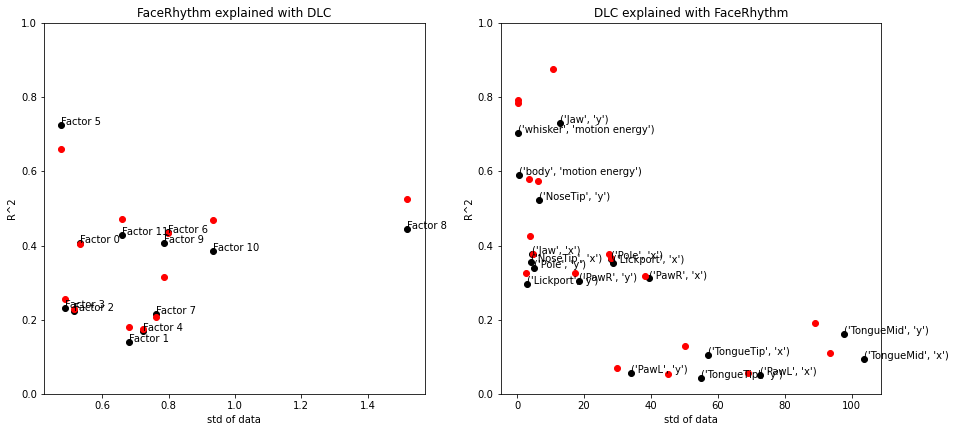

In [48]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso

filt_window = 10
# fit factors one by one
X = dlc_data.values#.rolling(window = 5).mean().values
#X[np.isnan(X)] = 0
xs = []
ys = []

fig = plt.figure(figsize = [15,15])
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)

for factor_name in facerhythm_data.keys():
    Y = facerhythm_data[factor_name].values
    lr = LinearRegression()   #Ridge(alpha = ridge_alpha)#Lasso(lasso_alpha/100)#
    lr.fit(X,Y)
    beta = lr.coef_
    intercept = lr.intercept_
    score_train=lr.score(X, Y)
    ax1.text(np.std(Y),score_train,factor_name)
    ys.append(score_train)
    xs.append(np.std(Y))
ax1.plot(xs,ys,'ko')
ax1.set_ylabel('R^2')
ax1.set_xlabel('std of data')
ax1.set_ylim([0,1])
ax1.set_title('FaceRhythm explained with DLC')


X = facerhythm_data.values
xs = []
ys = []
texts = []
for factor_name in dlc_data.keys():
    Y = dlc_data[factor_name].values
    #Y= BCI_analysis.plot_utils.rollingfun(Y,20,'mean')
    lr = LinearRegression()   #Ridge(alpha = ridge_alpha)#Lasso(lasso_alpha/100)#
    lr.fit(X,Y)
    beta = lr.coef_
    intercept = lr.intercept_
    score_train=lr.score(X, Y)
    #print([factor_name,score_train,np.std(Y)])
    ys.append(score_train)
    xs.append(np.std(Y))
    texts.append(factor_name)
    ax2.text(np.std(Y),score_train,factor_name)
ax2.plot(xs,ys,'ko')
ax2.set_title('DLC explained with FaceRhythm')
ax2.set_ylabel('R^2')
ax2.set_xlabel('std of data')
ax2.set_ylim([0,1])


# with filtering

X = dlc_data.rolling(window = filt_window).mean().values
X[np.isnan(X)] = 0
xs = []
ys = []

# ax1 = fig.add_subplot(2,2,3)
# ax2 = fig.add_subplot(2,2,4)

for factor_name in facerhythm_data.keys():
    Y = facerhythm_data[factor_name].values
    lr = LinearRegression()   #Ridge(alpha = ridge_alpha)#Lasso(lasso_alpha/100)#
    lr.fit(X,Y)
    beta = lr.coef_
    intercept = lr.intercept_
    score_train=lr.score(X, Y)
    #ax1.text(np.std(Y),score_train,factor_name)
    ys.append(score_train)
    xs.append(np.std(Y))
ax1.plot(xs,ys,'ro')
#ax1.set_ylabel('R^2')
#ax1.set_xlabel('std of data')
#ax1.set_ylim([0,1])
#ax1.set_title('FaceRhythm explained with filtered DLC')


X = facerhythm_data.values
xs = []
ys = []
texts = []
for factor_name in dlc_data.keys():
    Y = dlc_data[factor_name].values
    Y= BCI_analysis.plot_utils.rollingfun(Y,filt_window,'mean')
    lr = LinearRegression()   #Ridge(alpha = ridge_alpha)#Lasso(lasso_alpha/100)#
    lr.fit(X,Y)
    beta = lr.coef_
    intercept = lr.intercept_
    score_train=lr.score(X, Y)
    #print([factor_name,score_train,np.std(Y)])
    ys.append(score_train)
    xs.append(np.std(Y))
    texts.append(factor_name)
    #ax2.text(np.std(Y),score_train,factor_name)
ax2.plot(xs,ys,'ro')
#ax2.set_title('filtered DLC explained with FaceRhythm')
#ax2.set_ylabel('R^2')
#ax2.set_xlabel('std of data')
#ax2.set_ylim([0,1])

Text(0.5, 1.0, 'dlc')

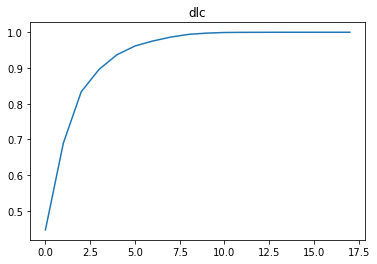

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=len(dlc_data.keys()), svd_solver='full')
pca.fit(dlc_data.values)
plt.plot(np.cumsum(pca.explained_variance_)/np.sum(pca.explained_variance_))
plt.title('dlc')

Text(0.5, 1.0, 'facerhythm')

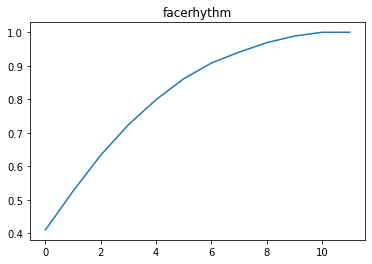

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=len(facerhythm_data.keys()), svd_solver='full')
pca.fit(facerhythm_data.values)
plt.plot(np.cumsum(pca.explained_variance_)/np.sum(pca.explained_variance_))
plt.title('facerhythm')